<a href="https://colab.research.google.com/github/hniu-tamu/ds_energy/blob/main/geopandas/1_intro_to_geopandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to GeoPandas

Haoyu Niu, Texas A&M University

Updated on Jan 16, 2024

Converted from

[GeoHackWeek 2019](https://geohackweek.github.io) -- [vector tutorial](https://geohackweek.github.io/vector/)   
[Emilio Mayorga, University of Washington](https://github.com/emiliom/). 2019-9-9

## 1. Introduction

[GeoPandas](http://geopandas.org) adds a spatial geometry data type to `Pandas` and enables spatial operations on these types, using [shapely](http://toblerity.org/shapely/). GeoPandas leverages Pandas together with several core open source geospatial packages and practices to provide a uniquely simple and convenient framework for handling geospatial feature data, operating on both geometries and attributes jointly, and as with Pandas, largely eliminating the need to iterate over features (rows). Also as with Pandas, it adds a very convenient and fine-tuned plotting method, and read/write methods that handle multiple geospatial file and "serialization" formats.

In [1]:
!pip install geopandas

## 2. Import packages, and set data file path
We'll use these throughout the rest of the tutorial.

In [2]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

In [3]:
mpl.__version__, pd.__version__, gpd.__version__

('3.7.1', '1.5.3', '0.13.2')

In [4]:
data_pth = Path("../data")

## 3. GeoSeries: The geometry building block

Like a Pandas `Series`, a `GeoSeries` is the building block for the more broadly useful and powerful `GeoDataFrame` that we'll focus on in this tutorial. Here we'll first take a bit of time to examine a `GeoSeries`.

A `GeoSeries` is made up of an index and a GeoPandas `geometry` data type. This data type is a [shapely.geometry object](http://toblerity.org/shapely/manual.html#geometric-objects), and therefore inherits their attributes and methods such as `area`, `bounds`, `distance`, etc.

GeoPandas has six classes of **geometric objects**, corresponding to the three basic single-entity geometric types and their associated homogeneous collections of multiple entities:
- **Single entity (core, basic types):**
  - Point
  - Line (*formally known as a LineString*)
  - Polygon
- **Homogeneous entity collections:**
  - Multi-Point
  - Multi-Line (*MultiLineString*)
  - Multi-Polygon

A `GeoSeries` is then a list of geometry objects and their associated index values.

<div class="alert alert-warning" style="font-size:100%">
<b style="font-size:120%">Entries (rows) in a GeoSeries can store different geometry types!</b></br></br>

GeoPandas does not constrain the geometry column to be of the same geometry type. This can lead to unexpected problems if you're not careful! Specially if you're used to thinking of a GIS file format like shape files, which store a single geometry type. Also beware that certain export operations (say, to shape files ...) will fail if the list of geometry objects is heterogeneous.
</div>

But enough theory! Let's get to the code. We'll start by illustrating how GeoSeries are constructured.

### Create a `GeoSeries` from a list of `shapely Point` objects using the `Point` constructor

In [5]:
gs = GeoSeries([Point(-120, 45), Point(-121.2, 46), Point(-122.9, 47.5)])
gs

0    POINT (-120.00000 45.00000)
1    POINT (-121.20000 46.00000)
2    POINT (-122.90000 47.50000)
dtype: geometry

In [6]:
type(gs), len(gs)

(geopandas.geoseries.GeoSeries, 3)

Occasionally -- but rarely -- you may encounter the need to parse and convert a geometry found as a `WKT` string. A `shapely Point` object can be constructed from it using`shapely.wkt.loads`:
```python
from shapely.wkt import loads
loads('POINT(-121.2 46)')
```

A GeoSeries (and a GeoDataFrame) can store a CRS implicitly associated with the geometry column. This is useful as essential spatial metadata and for transformation (reprojection) to another CRS. Let's assign the CRS, then plot it.

In [7]:
gs.crs = {'init': 'epsg:4326'}

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

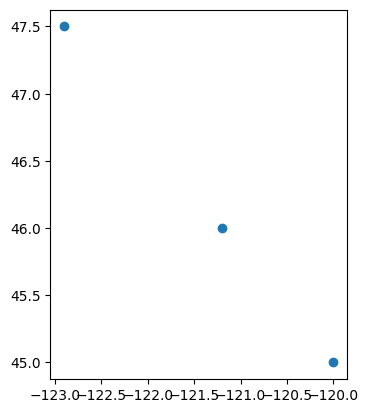

In [8]:
gs.plot()

The `plot` method accepts standard `matplotlib.pyplot` style options, and can be tweaked like any other `matplotlib` figure.

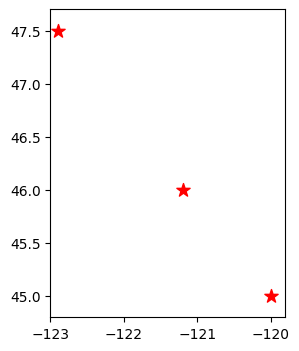

In [9]:
gs.plot(marker='*', color='red', markersize=100, figsize=(4, 4))
plt.xlim([-123, -119.8])
plt.ylim([44.8, 47.7]);

**Let's get a bit fancier, as a stepping stone to GeoDataFrames.** First, we'll define a simple dictionary of lists, that we'll use again later.

In [10]:
data = {'name': ['a', 'b', 'c'],
        'lat': [45, 46, 47.5],
        'lon': [-120, -121.2, -122.9]}

Note this convenient, compact approach to create a list of `Point` shapely objects out of X & Y coordinate lists using the `gpd.points_from_xy` convenience method (introduced in version 0.5.0). The same result could be obtained with the more verbose form `geometry = [Point(x,y) for x,y in zip(data['lon'], data['lat'])]`.

In [11]:
geometry = gpd.points_from_xy(data['lon'], data['lat'])

We'll wrap up by creating a GeoSeries where we explicitly define the index values.

In [12]:
gs = GeoSeries(geometry, index=data['name'])
gs

a    POINT (-120.00000 45.00000)
b    POINT (-121.20000 46.00000)
c    POINT (-122.90000 47.50000)
dtype: geometry

## 4. GeoDataFrames: The real power tool

<div class="alert alert-info" style="font-size:100%">

It's worth noting that a GeoDataFrame can be described as a **Feature Collection**, where each row is a *Feature*, a *geometry* column is defined (thought the name of the column doesn't have to be "geometry"), and the attribute *properties* includes the other columns (the Pandas DataFrame part, if you will).

</div>

<div class="alert alert-warning" style="font-size:100%">

More than one column can store geometry objects! We won't explore this capability in this tutorial.

</div>

### Start with a simple, manually constructed illustration

We'll build on the GeoSeries examples. Let's reuse the `data` dictionary we defined earlier, this time to create a DataFrame.

In [13]:
df = pd.DataFrame(data)
df

,name,lat,lon
0,a,45.0,-120.0
1,b,46.0,-121.2
2,c,47.5,-122.9


Now we use the DataFrame and `points_from_xy` (which creates a list of shapely Point objects) to create a GeoDataFrame. Note the use of two DataFrame attribute columns, which are effectively just two simple Pandas Series.

In [14]:
gdf = GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))

In [15]:
gdf

,name,lat,lon,geometry
0,a,45.0,-120.0,POINT (-120.00000 45.00000)
1,b,46.0,-121.2,POINT (-121.20000 46.00000)
2,c,47.5,-122.9,POINT (-122.90000 47.50000)


There's nothing new to visualize, but this time we're using the `plot` method from a GeoDataFrame, *not* from a GeoSeries. They're not exactly the same thing under the hood.

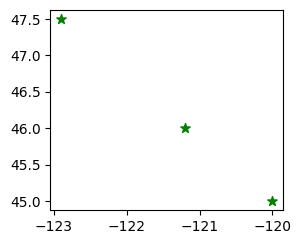

In [16]:
gdf.plot(marker='*', color='green', markersize=50, figsize=(3, 3));

### FINALLY, we get to work with real data! Load and examine the simple "oceans" shape file

`gpd.read_file` is the workhorse for reading GIS files. It leverages the [fiona](http://toblerity.org/fiona/README.html) package.

In [17]:
!wget https://github.com/geohackweek/tutorial_contents/raw/master/vector/data/oceans.shp
!wget https://github.com/geohackweek/tutorial_contents/raw/master/vector/data/oceans.shx

--2024-01-17 02:48:18--  https://github.com/geohackweek/tutorial_contents/raw/master/vector/data/oceans.shp
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/geohackweek/tutorial_contents/master/vector/data/oceans.shp [following]
--2024-01-17 02:48:19--  https://raw.githubusercontent.com/geohackweek/tutorial_contents/master/vector/data/oceans.shp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7428 (7.3K) [application/octet-stream]
Saving to: ‘oceans.shp’

oceans.shp          100%[===================>]   7.25K  --.-KB/s    in 0s      

2024-01-17 02:48:19 (75.8 MB/s) - ‘oceans.shp’ saved [7428/742

In [18]:
oceans = gpd.read_file("./oceans.shp")

In [19]:
oceans.head()

,geometry
0,"POLYGON ((-67.26026 -59.93092, -67.27089 -58.1..."
1,"MULTIPOLYGON (((180.00000 66.27035, 180.00000 ..."
2,"POLYGON ((180.00000 -60.00000, 180.00000 -90.0..."
3,"POLYGON ((-100.11965 52.89103, -105.38349 53.3..."
4,"POLYGON ((19.69706 -59.94160, 19.72237 -54.348..."


The `crs` was read from the shape file's `prj` file:

In [20]:
oceans.crs

Now we finally plot a real map (or blobs, depending on your aesthetics), from a dataset that's global-scale and stored in "geographic" (latitude & longitude) coordinates. It's *not* the actual ocean shapes defined by coastal boundaries, but bear with me. A colormap has been applied to distinguish the different "oceans".

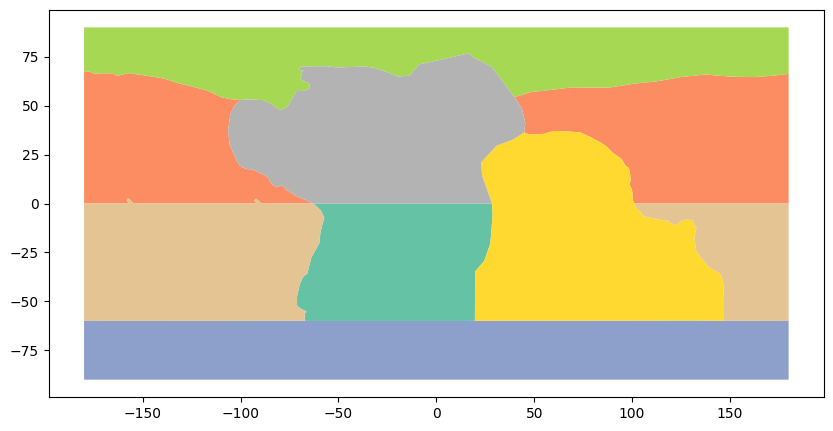

In [21]:
oceans.plot(cmap='Set2', figsize=(10, 10));

`oceans.shp` stores both `Polygon` and `Multi-Polygon` geometry types (a `Polygon` may also be viewed as a `Multi-Polygon` with 1 member). We can get at the geometry types and other geometry properties easily.

In [22]:
oceans.geom_type

0         Polygon
1    MultiPolygon
2         Polygon
3         Polygon
4         Polygon
5    MultiPolygon
6         Polygon
dtype: object

In [23]:
# Beware that these area calculations are in the native degrees units, which is fairly useless
oceans.geometry.area

0     5287.751094
1    11805.894558
2    10822.509589
3     9578.786157
4     9047.879388
5     9640.457926
6     8616.721287
dtype: float64

In [24]:
oceans.geometry.bounds

,minx,miny,maxx,maxy
0,-71.183612,-60.000000,28.736134,0.000000
1,-180.000000,0.000000,180.000000,67.479386
2,-180.000000,-90.000000,180.000000,-59.806846
3,-180.000000,47.660532,180.000000,90.000000
4,19.697056,-59.945004,146.991853,37.102940
5,-180.000000,-60.000000,180.000000,2.473291
6,-106.430148,0.000000,45.468236,76.644442


The `envelope` method returns the bounding box for each polygon. This could be used to create a new spatial column or GeoSeries; directly for plotting; etc.

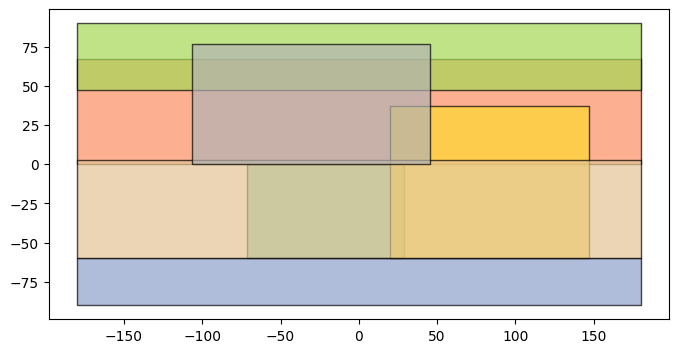

In [25]:
oceans.envelope.plot(cmap='Set2', figsize=(8, 8), alpha=0.7, edgecolor='black');

Does it seem weird that some envelope bounding boxes, such as the North Pacific Ocean, span all longitudes? That's because they're Multi-Polygons with edges at the ends of the -180 and +180 degree coordinate range.

### Load "Natural Earth" countries dataset, bundled with GeoPandas
*"[Natural Earth](http://www.naturalearthdata.com) is a public domain map dataset available at 1:10m, 1:50m, and 1:110 million scales. Featuring tightly integrated vector and raster data, with Natural Earth you can make a variety of visually pleasing, well-crafted maps with cartography or GIS software."* A subset comes bundled with GeoPandas and is accessible from the `gpd.datasets` module. We'll use it as a helpful global base layer map.

In [26]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(2)

<ipython-input-26-5fb0c8b442e0>:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."


Its CRS is also EPSG:4326:

In [27]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

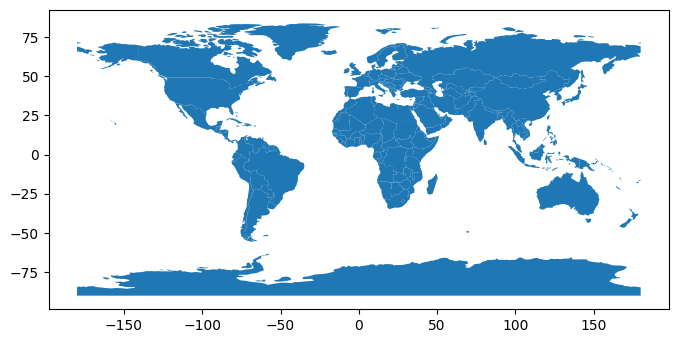

In [28]:
world.plot(figsize=(8, 8));

### Map plot overlays: Plotting multiple spatial layers

Here's a compact, quick way of using the GeoDataFrame plot method to overlay two GeoDataFrames while customizing the styles for each layer. The "inner" plot (`oceans`) is displayed in the background.

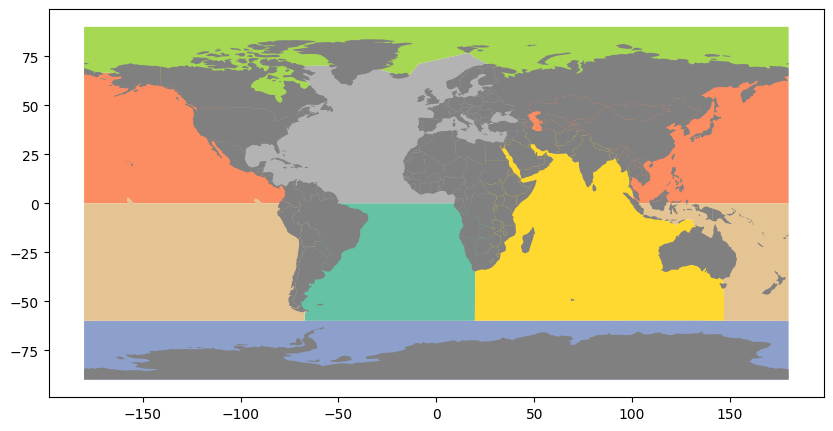

In [29]:
world.plot(ax=oceans.plot(cmap='Set2', figsize=(10, 10)),
           facecolor='gray');

We can also compose the plot using conventional `matplotlib` steps and options that give us more control.

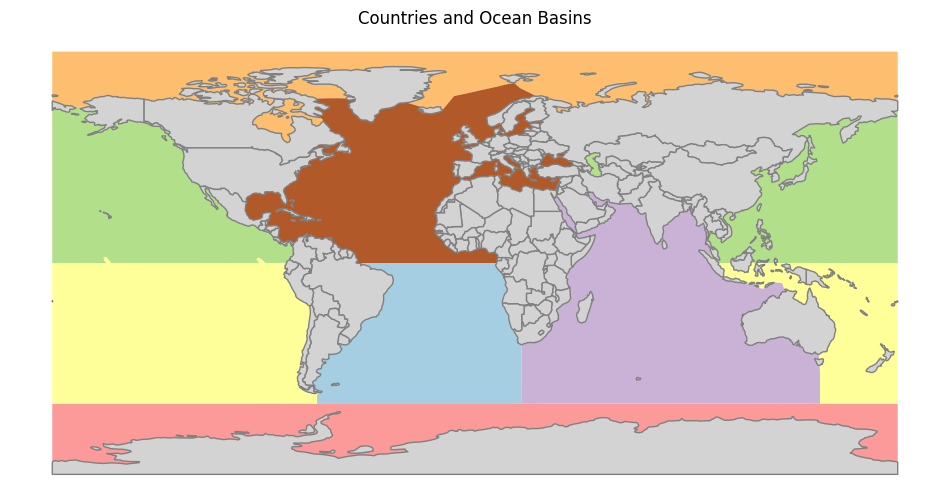

In [30]:
f, ax = plt.subplots(1, figsize=(12, 6))
ax.set_title('Countries and Ocean Basins')
# Other nice categorical color maps (cmap) include 'Set2' and 'Set3'
oceans.plot(ax=ax, cmap='Paired')
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
ax.set_ylim([-90, 90])
ax.set_axis_off()
plt.axis('equal');

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Time to Explore</b></br>

Let's stop for a bit to explore on your own, hack with your neighbors, ask questions.

</div>